## Import the libraries we'll be using.

In [23]:
# Global imports and settings

# OS for I/O operations
import os
import csv
import glob
from collections import OrderedDict

# Matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["figure.max_open_warning"] = -1

# Numpy & print options
import numpy as np
np.set_printoptions(precision=3)

# Pandas
import pandas as pd

# Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn import svm

# Sklearn-pandas
from sklearn_pandas import DataFrameMapper, cross_val_score

# Silence warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

## Import all CSVs in the `data` subdirectory

In [24]:
path = os.path.join(os.getcwd(), 'data') # pull files from the 'data' subdirectory
allFiles = glob.glob(path + "/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    print('Reading file:' + file_)
    this_df = pd.read_csv(file_,index_col=None, header=0)
    this_df['user'] = os.path.basename(file_)[0:36] # just grab the user id hash
    list_.append(this_df)
df = pd.concat(list_)

print df.columns
print df.shape

Reading file:/Users/afaucher/Documents/Grad School 2017/CMU HCI/Courses/_0X Applied ML/Assignments/Final Project/_Notebook/data/0BFC35E2-4817-4865-BFA7-764742302A2D.features_labels.csv
Reading file:/Users/afaucher/Documents/Grad School 2017/CMU HCI/Courses/_0X Applied ML/Assignments/Final Project/_Notebook/data/0A986513-7828-4D53-AA1F-E02D6DF9561B.features_labels.csv
Reading file:/Users/afaucher/Documents/Grad School 2017/CMU HCI/Courses/_0X Applied ML/Assignments/Final Project/_Notebook/data/0E6184E1-90C0-48EE-B25A-F1ECB7B9714E.features_labels.csv
Index([u'timestamp', u'raw_acc:magnitude_stats:mean',
       u'raw_acc:magnitude_stats:std', u'raw_acc:magnitude_stats:moment3',
       u'raw_acc:magnitude_stats:moment4',
       u'raw_acc:magnitude_stats:percentile25',
       u'raw_acc:magnitude_stats:percentile50',
       u'raw_acc:magnitude_stats:percentile75',
       u'raw_acc:magnitude_stats:value_entropy',
       u'raw_acc:magnitude_stats:time_entropy',
       ...
       u'label:ELEVAT

In [25]:
df.head()

,timestamp,raw_acc:magnitude_stats:mean,raw_acc:magnitude_stats:std,raw_acc:magnitude_stats:moment3,raw_acc:magnitude_stats:moment4,raw_acc:magnitude_stats:percentile25,raw_acc:magnitude_stats:percentile50,raw_acc:magnitude_stats:percentile75,raw_acc:magnitude_stats:value_entropy,raw_acc:magnitude_stats:time_entropy,...,label:ELEVATOR,label:OR_standing,label:AT_SCHOOL,label:PHONE_IN_HAND,label:PHONE_IN_BAG,label:PHONE_ON_TABLE,label:WITH_CO-WORKERS,label:WITH_FRIENDS,label_source,user
0,1445366534,1.023488,0.024622,-0.028726,0.066325,1.018790,1.021975,1.026449,0.765474,6.684317,...,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2,0BFC35E2-4817-4865-BFA7-764742302A2D
1,1445366594,1.025689,0.065634,0.042226,0.129952,1.011969,1.020782,1.032243,1.446182,6.682553,...,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2,0BFC35E2-4817-4865-BFA7-764742302A2D
2,1445366674,1.022835,0.039641,-0.052978,0.100098,1.020100,1.022686,1.025343,0.616602,6.683829,...,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2,0BFC35E2-4817-4865-BFA7-764742302A2D
3,1445366703,1.022907,0.008549,-0.015235,0.029863,1.020766,1.022855,1.025048,0.807471,6.684576,...,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2,0BFC35E2-4817-4865-BFA7-764742302A2D
4,1445366761,1.023375,0.011622,0.017318,0.030025,1.020367,1.022504,1.024599,0.682306,6.684548,...,NaN,0.0,1.0,NaN,NaN,NaN,0.0,0.0,2,0BFC35E2-4817-4865-BFA7-764742302A2D


## Rename and select the features we actually want to use.

In [29]:
# What is the class value we'll want to predict?
# This is pulled out separately here for convenience

class_ft = 'label:LOC_home'
class_ft_renamed = 'b_class_home'

# Create a dictionary that will let us simultaneously rename and select our feature values
renamed_ft = OrderedDict([
    
    ### USER REFERENCE ###
    ('user','s_user'),
    
    ### NUMERIC FEATURES ###
        
    # Timestamp
    ('timestamp','i_t'),
    
    # Accelerometer Features
    ('raw_acc:magnitude_stats:percentile25','f_acc_p25'),
    ('raw_acc:magnitude_stats:percentile50','f_acc_p50'),
    ('raw_acc:magnitude_stats:percentile75','f_acc_p75'),
    ('raw_acc:magnitude_stats:value_entropy','f_acc_vEnt'),
    ('raw_acc:magnitude_stats:time_entropy','f_acc_tEnt'),
    ('raw_acc:magnitude_autocorrelation:period','f_acc_acPer'),
    ('raw_acc:magnitude_autocorrelation:normalized_ac','f_acc_accNor'),
    
    # Gyroscope Features
    ('proc_gyro:magnitude_stats:mean','f_gyr_mean'),
    ('proc_gyro:magnitude_stats:std','f_gyr_std'),
    ('proc_gyro:magnitude_stats:percentile25','f_gyr_p25'),
    ('proc_gyro:magnitude_stats:percentile50','f_gyr_p50'),
    ('proc_gyro:magnitude_stats:percentile75','f_gyr_p75'),
    ('proc_gyro:magnitude_stats:value_entropy','f_gyr_vEnt'),
    ('proc_gyro:magnitude_autocorrelation:period','f_gyr_acPer'),
    ('proc_gyro:magnitude_autocorrelation:normalized_ac','f_gyr_acNor'),
    # Location Features
    ('location_quick_features:std_lat','f_loc_latStd'),
    ('location_quick_features:std_long','f_loc_longStd'),
    ('location_quick_features:lat_change','f_loc_latChg'),
    ('location_quick_features:long_change','f_loc_longChg'),
    ('location_quick_features:mean_abs_lat_deriv','f_loc_latAbsDv'),
    ('location_quick_features:mean_abs_long_deriv','f_loc_longAbsDv'),
    # Audio Features
    ('audio_properties:max_abs_value','f_aud_AbsMax'),

    ### BINARY FEATURES ###

    # App Status
    ('discrete:app_state:is_active','b_appSt_Act'),
    ('discrete:app_state:is_inactive','b_appSt_InAct'),
    ('discrete:app_state:is_background','b_appSt_Bkg'),
    ('discrete:app_state:missing','b_appSt_Miss'),
    # Battery
    ('discrete:battery_plugged:is_ac','b_battPlg_Ac'),
    ('discrete:battery_plugged:is_usb','b_battPlg_Usb'),
    ('discrete:battery_plugged:is_wireless','b_battPlg_Wrls'),
    ('discrete:battery_plugged:missing','b_battPlg_Miss'),
    ('discrete:battery_state:is_unknown','b_battSt_Unk'),
    ('discrete:battery_state:is_unplugged','b_battSt_Unplg'),
    ('discrete:battery_state:is_not_charging','b_battSt_NtChrg'),
    ('discrete:battery_state:is_discharging','b_battSt_DsChrg'),
    ('discrete:battery_state:is_charging','b_battSt_Chrg'),
    ('discrete:battery_state:is_full','b_battSt_Full'),
    ('discrete:battery_state:missing','b_battSt_Miss'),
    # On the Phone
    ('discrete:on_the_phone:is_False','b_onPhn_F'),
    ('discrete:on_the_phone:is_True','b_onPhn_T'),
    ('discrete:on_the_phone:missing','b_onPhn_Miss'),
    # Ringer Mode
    ('discrete:ringer_mode:is_normal','b_ringMd_Norm'),
    ('discrete:ringer_mode:is_silent_no_vibrate','b_ringMd_silNV'),
    ('discrete:ringer_mode:is_silent_with_vibrate','b_ringMd_silV'),
    ('discrete:ringer_mode:missing','b_ringMd_Miss'),
    # Wifi Status
    ('discrete:wifi_status:is_not_reachable','b_wifiSt_nr'),
    ('discrete:wifi_status:is_reachable_via_wifi','b_wifiSt_rWifi'),
    ('discrete:wifi_status:is_reachable_via_wwan','b_wifiSt_rWwan'),
    ('discrete:wifi_status:missing','b_wifiSt_Miss'),
    # Time of Day: Format 1
    ('discrete:time_of_day:between0and6','b_time_0_6'),
    ('discrete:time_of_day:between6and12','b_time_6_12'),
    ('discrete:time_of_day:between12and18','b_time_12_18'),
    ('discrete:time_of_day:between18and24','b_time_18_24'),    
    # Time of Day: Format 2    
    ('discrete:time_of_day:between3and9','b_time_3_9'),
    ('discrete:time_of_day:between9and15','b_time_9_15'),
    ('discrete:time_of_day:between15and21','b_time_15_21'),
    ('discrete:time_of_day:between21and3','b_time_21_3'),

    ### CLASS ###
    (class_ft, class_ft_renamed)
])

# print renamed_ft

# Rename columns based on the dictionary
df = df.rename(columns=renamed_ft)
# df.head()

# Trim the DataFrame to include only relevant features
relevant_ft = renamed_ft.values()
# print 'Relevant features:'
# print relevant_ft
df = df[relevant_ft]
df.head()


,s_user,i_t,f_acc_p25,f_acc_p50,f_acc_p75,f_acc_vEnt,f_acc_tEnt,f_acc_acPer,f_acc_accNor,f_gyr_mean,...,b_wifiSt_Miss,b_time_0_6,b_time_6_12,b_time_12_18,b_time_18_24,b_time_3_9,b_time_9_15,b_time_15_21,b_time_21_3,b_class_home
0,0BFC35E2-4817-4865-BFA7-764742302A2D,1445366534,1.018790,1.021975,1.026449,0.765474,6.684317,0.482794,0.073672,0.246308,...,False,False,True,False,False,False,True,False,False,False
1,0BFC35E2-4817-4865-BFA7-764742302A2D,1445366594,1.011969,1.020782,1.032243,1.446182,6.682553,7.221784,0.143749,0.357748,...,False,False,True,False,False,False,True,False,False,False
2,0BFC35E2-4817-4865-BFA7-764742302A2D,1445366674,1.020100,1.022686,1.025343,0.616602,6.683829,3.600838,0.146281,0.019397,...,False,False,True,False,False,False,True,False,False,False
3,0BFC35E2-4817-4865-BFA7-764742302A2D,1445366703,1.020766,1.022855,1.025048,0.807471,6.684576,3.962931,0.277193,0.004336,...,False,False,True,False,False,False,True,False,False,False
4,0BFC35E2-4817-4865-BFA7-764742302A2D,1445366761,1.020367,1.022504,1.024599,0.682306,6.684548,2.936994,0.141068,0.007220,...,False,False,True,False,False,False,True,False,False,False


## Eliminate instances where the class value is `NaN`

In [30]:
print('Before NaN elimination: ' + str(df.shape))
df = df.dropna(axis=0, subset
               =[class_ft_renamed])
print('After NaN elimination: ' + str(df.shape))

Before NaN elimination: (14589, 59)
After NaN elimination: (14589, 59)


## Assign the right `dtypes` to these features.

In [31]:
for col in df.columns:
    
    # If the column starts with 'discrete' or 'label',
    # make it a 'bool' dtype.
    if col.startswith('b_'):
        df[col] = df[col].astype(bool)
    elif col.startswith('s_'):
        df[col] = df[col].astype(str)
    elif col.startswith('i_'):
        df[col] = df[col].astype(int)
    elif col.startswith('f_'):
        df[col] = df[col].astype(float)
    


In [32]:
df.dtypes

s_user              object
i_t                  int64
f_acc_p25          float64
f_acc_p50          float64
f_acc_p75          float64
f_acc_vEnt         float64
f_acc_tEnt         float64
f_acc_acPer        float64
f_acc_accNor       float64
f_gyr_mean         float64
f_gyr_std          float64
f_gyr_p25          float64
f_gyr_p50          float64
f_gyr_p75          float64
f_gyr_vEnt         float64
f_gyr_acPer        float64
f_gyr_acNor        float64
f_loc_latStd       float64
f_loc_longStd      float64
f_loc_latChg       float64
f_loc_longChg      float64
f_loc_latAbsDv     float64
f_loc_longAbsDv    float64
f_aud_AbsMax       float64
b_appSt_Act           bool
b_appSt_InAct         bool
b_appSt_Bkg           bool
b_appSt_Miss          bool
b_battPlg_Ac          bool
b_battPlg_Usb         bool
b_battPlg_Wrls        bool
b_battPlg_Miss        bool
b_battSt_Unk          bool
b_battSt_Unplg        bool
b_battSt_NtChrg       bool
b_battSt_DsChrg       bool
b_battSt_Chrg         bool
b

In [20]:
df.head()

,user,t,n_acc_p25,n_acc_p50,n_acc_p75,n_acc_vEnt,n_acc_tEnt,n_acc_acPer,n_acc_accNor,n_gyr_mean,...,b_wifiSt_Miss,b_time_0_6,b_time_6_12,b_time_12_18,b_time_18_24,b_time_3_9,b_time_9_15,b_time_15_21,b_time_21_3,class_home
0,0BFC35E2-4817-4865-BFA7-764742302A2D,1.445367e+09,1.018790,1.021975,1.026449,0.765474,6.684317,0.482794,0.073672,0.246308,...,False,False,True,False,False,False,True,False,False,False
1,0BFC35E2-4817-4865-BFA7-764742302A2D,1.445367e+09,1.011969,1.020782,1.032243,1.446182,6.682553,7.221784,0.143749,0.357748,...,False,False,True,False,False,False,True,False,False,False
2,0BFC35E2-4817-4865-BFA7-764742302A2D,1.445367e+09,1.020100,1.022686,1.025343,0.616602,6.683829,3.600838,0.146281,0.019397,...,False,False,True,False,False,False,True,False,False,False
3,0BFC35E2-4817-4865-BFA7-764742302A2D,1.445367e+09,1.020766,1.022855,1.025048,0.807471,6.684576,3.962931,0.277193,0.004336,...,False,False,True,False,False,False,True,False,False,False
4,0BFC35E2-4817-4865-BFA7-764742302A2D,1.445367e+09,1.020367,1.022504,1.024599,0.682306,6.684548,2.936994,0.141068,0.007220,...,False,False,True,False,False,False,True,False,False,False


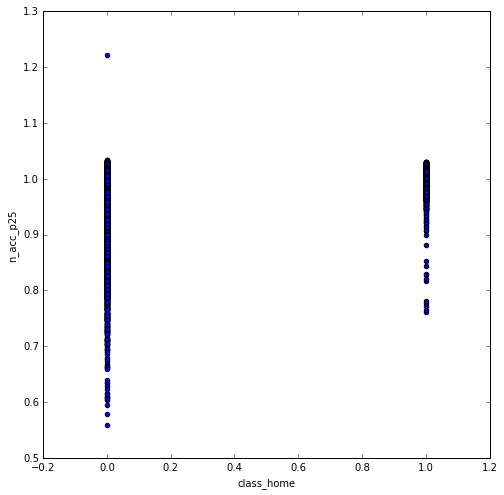

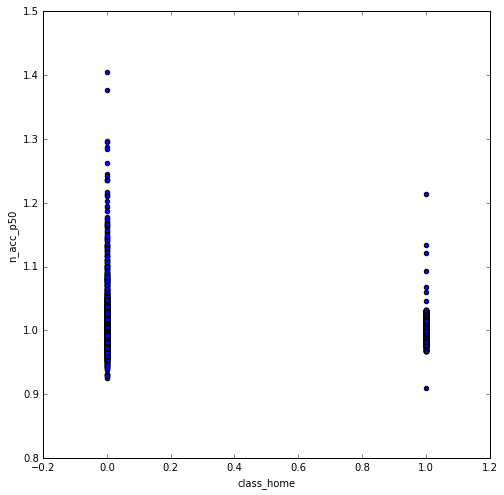

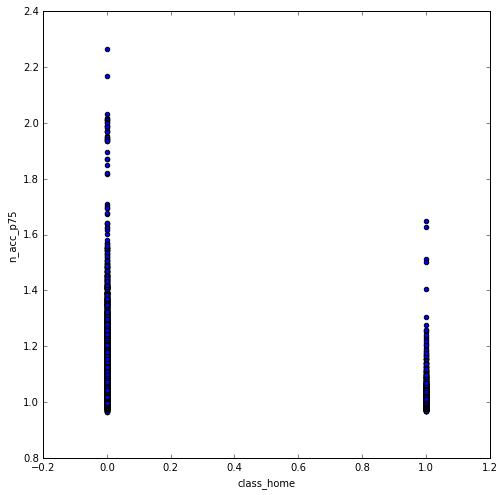

In [21]:
df.plot.scatter(x='class_home',y='n_acc_p25')
df.plot.scatter(x='class_home',y='n_acc_p50')
df.plot.scatter(x='class_home',y='n_acc_p75')

In [22]:
df2 = df[['b_time_6_12','class_home']].copy()
df2 = df2.head()

print df2

  b_time_6_12 class_home
0        True      False
1        True      False
2        True      False
3        True      False
4        True      False
